Dependencies

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from typing import List
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchvision import models
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image
import random
import time
import copy

In [67]:
#Lets use mps if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [68]:
train_df = pd.read_csv('archive/train.csv')
val_df = pd.read_csv('archive/val.csv')

train_df['image:FILE'] = 'archive/' + train_df['image:FILE']
val_df['image:FILE'] = 'archive/' + val_df['image:FILE']
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Training samples: 1034
Validation samples: 133


In [69]:
print(train_df.head())
print(val_df.head())


                                    image:FILE  category
0   archive/train/healthy/healthy_train.98.jpg         0
1  archive/train/healthy/healthy_train.148.jpg         0
2  archive/train/healthy/healthy_train.306.jpg         0
3  archive/train/healthy/healthy_train.305.jpg         0
4   archive/train/healthy/healthy_train.40.jpg         0
                               image:FILE  category
0  archive/val/healthy/healthy_val.25.jpg         0
1  archive/val/healthy/healthy_val.32.jpg         0
2   archive/val/healthy/healthy_val.3.jpg         0
3  archive/val/healthy/healthy_val.16.jpg         0
4  archive/val/healthy/healthy_val.10.jpg         0


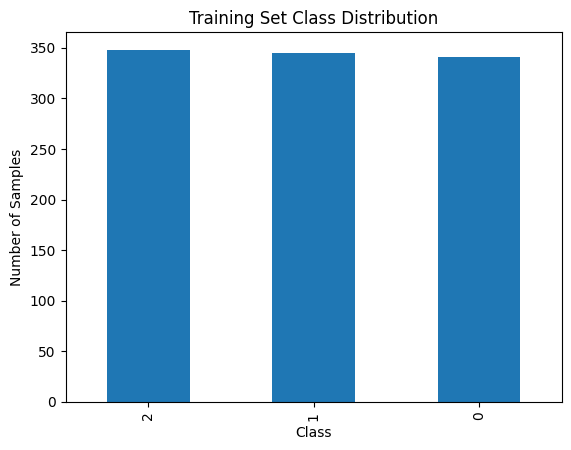

In [70]:
train_df['category'].value_counts().plot.bar()
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

In [71]:
#Shapes
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

Train shape: (1034, 2)
Validation shape: (133, 2)


In [72]:
#class names
class_names = train_df['category'].unique().tolist()
print(f"Class names: {class_names}")

Class names: [0, 1, 2]


In [73]:
#Map class names to indices with actual class names
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}  
print(f"Class to index mapping: {class_to_idx}")    

Class to index mapping: {0: 0, 1: 1, 2: 2}


In [93]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# train_dataset = CustomImageDataset(train_df, transform=train_transform)
# val_dataset = CustomImageDataset(val_df, transform=val_transform)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Dataset Customization

In [94]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = [class_to_idx[cat] for cat in self.dataframe['category'].tolist()]
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image).to(device)  # Remove the /255.0 !
        return image, label
train_dataset = CustomImageDataset(train_df, transform=train_transform)
val_dataset = CustomImageDataset(val_df, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")   



Number of training batches: 33
Number of validation batches: 5


View Some images

Image shape: torch.Size([3, 128, 128]), Min: 0.0, Max: 0.9882352948188782
Image shape: torch.Size([3, 128, 128]), Min: 0.019607843831181526, Max: 0.9882352948188782
Image shape: torch.Size([3, 128, 128]), Min: 0.0, Max: 1.0
Image shape: torch.Size([3, 128, 128]), Min: 0.0, Max: 0.95686274766922
Image shape: torch.Size([3, 128, 128]), Min: 0.0, Max: 0.9843137264251709
Image shape: torch.Size([3, 128, 128]), Min: 0.0, Max: 1.0
Image shape: torch.Size([3, 128, 128]), Min: 0.0, Max: 1.0
Image shape: torch.Size([3, 128, 128]), Min: 0.03529411926865578, Max: 0.9921568632125854
Image shape: torch.Size([3, 128, 128]), Min: 0.0, Max: 0.9960784316062927


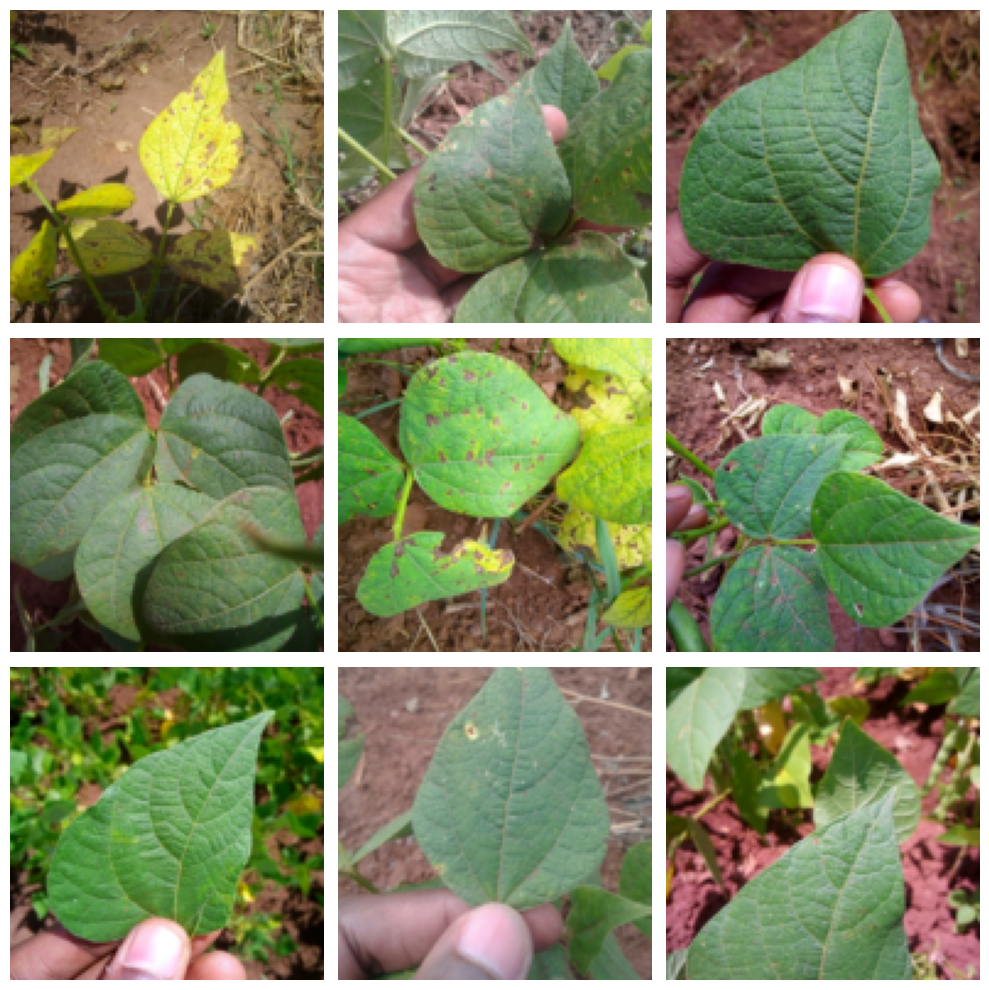

In [95]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols, figsize=(10,10))
for i in range(n_rows):
    for j in range(n_cols):
        image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
        
        # Debug: check the actual values
        print(f"Image shape: {image.shape}, Min: {image.min()}, Max: {image.max()}")
        
        # Handle both grayscale and RGB
        if image.shape[0] == 1:  # Grayscale
            axarr[i,j].imshow(image.squeeze(), cmap='gray')
        else:  # RGB
            axarr[i,j].imshow(image.permute(1,2,0))
        
        axarr[i,j].axis('off')
plt.tight_layout()
plt.show()

In [96]:
LR = 1e-3
EPOCHS = 15
BATCH_SIZE = 32

In [97]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")   


Number of training batches: 259
Number of validation batches: 34


In [98]:
google_net = models.googlenet(weights='DEFAULT')

Training entire Weights without new layers

In [99]:
for param in google_net.parameters():
    param.requires_grad = True

In [100]:
google_net.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [101]:
num_classes = len(train_df['category'].unique())
google_net.fc = nn.Linear(in_features=1024, out_features=num_classes)
google_net = google_net.to(device)


In [102]:
google_net.fc

Linear(in_features=1024, out_features=3, bias=True)

In [103]:
google_net.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [105]:
from tqdm import tqdm

loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(google_net.parameters(), lr=LR)
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    
    for batch_idx, (inputs, labels) in enumerate(train_bar, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = google_net(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()
        
        # Show running averages (more informative)
        avg_loss = total_loss_train / batch_idx
        avg_acc = total_acc_train / (batch_idx * inputs.size(0)) * 100
        train_bar.set_postfix({'avg_loss': f'{avg_loss:.4f}', 'avg_acc': f'{avg_acc:.2f}%'})
    
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {total_loss_train/len(train_loader):.4f}, Training Accuracy: {total_acc_train/train_dataset.__len__()*100:.2f}%")

Epoch 1/15: 100%|██████████| 259/259 [00:21<00:00, 12.21it/s, avg_loss=0.8119, avg_acc=132.63%]


Epoch 1/15, Training Loss: 0.8119, Training Accuracy: 66.44%


Epoch 2/15: 100%|██████████| 259/259 [00:20<00:00, 12.48it/s, avg_loss=0.7048, avg_acc=142.47%]


Epoch 2/15, Training Loss: 0.7048, Training Accuracy: 71.37%


Epoch 3/15: 100%|██████████| 259/259 [00:20<00:00, 12.51it/s, avg_loss=0.5675, avg_acc=158.88%]


Epoch 3/15, Training Loss: 0.5675, Training Accuracy: 79.59%


Epoch 4/15: 100%|██████████| 259/259 [00:21<00:00, 12.08it/s, avg_loss=0.4425, avg_acc=166.41%]


Epoch 4/15, Training Loss: 0.4425, Training Accuracy: 83.37%


Epoch 5/15: 100%|██████████| 259/259 [00:20<00:00, 12.62it/s, avg_loss=0.3968, avg_acc=172.97%]


Epoch 5/15, Training Loss: 0.3968, Training Accuracy: 86.65%


Epoch 6/15: 100%|██████████| 259/259 [00:20<00:00, 12.46it/s, avg_loss=0.3572, avg_acc=174.90%]


Epoch 6/15, Training Loss: 0.3572, Training Accuracy: 87.62%


Epoch 7/15: 100%|██████████| 259/259 [00:20<00:00, 12.70it/s, avg_loss=0.3188, avg_acc=177.03%]


Epoch 7/15, Training Loss: 0.3188, Training Accuracy: 88.68%


Epoch 8/15: 100%|██████████| 259/259 [00:20<00:00, 12.90it/s, avg_loss=0.2987, avg_acc=180.12%]


Epoch 8/15, Training Loss: 0.2987, Training Accuracy: 90.23%


Epoch 9/15: 100%|██████████| 259/259 [00:21<00:00, 12.13it/s, avg_loss=0.2504, avg_acc=181.66%]


Epoch 9/15, Training Loss: 0.2504, Training Accuracy: 91.01%


Epoch 10/15: 100%|██████████| 259/259 [00:21<00:00, 11.99it/s, avg_loss=0.2355, avg_acc=181.08%]


Epoch 10/15, Training Loss: 0.2355, Training Accuracy: 90.72%


Epoch 11/15: 100%|██████████| 259/259 [00:22<00:00, 11.56it/s, avg_loss=0.2017, avg_acc=183.98%]


Epoch 11/15, Training Loss: 0.2017, Training Accuracy: 92.17%


Epoch 12/15: 100%|██████████| 259/259 [00:21<00:00, 12.30it/s, avg_loss=0.2038, avg_acc=184.75%]


Epoch 12/15, Training Loss: 0.2038, Training Accuracy: 92.55%


Epoch 13/15: 100%|██████████| 259/259 [00:20<00:00, 12.60it/s, avg_loss=0.1584, avg_acc=189.77%]


Epoch 13/15, Training Loss: 0.1584, Training Accuracy: 95.07%


Epoch 14/15: 100%|██████████| 259/259 [00:21<00:00, 12.02it/s, avg_loss=0.1874, avg_acc=188.22%]


Epoch 14/15, Training Loss: 0.1874, Training Accuracy: 94.29%


Epoch 15/15: 100%|██████████| 259/259 [00:23<00:00, 10.89it/s, avg_loss=0.1174, avg_acc=191.31%]

Epoch 15/15, Training Loss: 0.1174, Training Accuracy: 95.84%


In [108]:
with torch.no_grad():
    total_acc_val = 0
    total_loss_val = 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = google_net(inputs)

        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_val += acc

        val_loss = loss_fun(predictions, labels)
        total_loss_val += val_loss.item()   

    print(f"Validation Loss: {total_loss_val/len(val_loader):.4f}, Validation Accuracy: {total_acc_val/val_dataset.__len__()*100:.2f}%")

Validation Loss: 1.3379, Validation Accuracy: 66.17%


In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), total_loss_train_plot, label='Training Loss')
plt.title('GoogLeNet Full Training - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), total_acc_train_plot, label='Training Accuracy')
plt.title('GoogLeNet Full Training - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Transfer Learning

In [106]:
Google_Transfer = models.googlenet(weights='DEFAULT')

for param in Google_Transfer.parameters():
    param.requires_grad = False
Google_Transfer.fc = nn.Linear(in_features=1024, out_features=num_classes)
Google_Transfer = Google_Transfer.to(device)
Google_Transfer.fc.to(device)


Linear(in_features=1024, out_features=3, bias=True)

In [107]:
from tqdm import tqdm

loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(Google_Transfer.parameters(), lr=LR)
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    
    for batch_idx, (inputs, labels) in enumerate(train_bar, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = Google_Transfer(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()
        
        # Show running averages (more informative)
        avg_loss = total_loss_train / batch_idx
        avg_acc = total_acc_train / (batch_idx * inputs.size(0)) * 100
        train_bar.set_postfix({'avg_loss': f'{avg_loss:.4f}', 'avg_acc': f'{avg_acc:.2f}%'})
    
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {total_loss_train/len(train_loader):.4f}, Training Accuracy: {total_acc_train/train_dataset.__len__()*100:.2f}%")

Epoch 1/15: 100%|██████████| 259/259 [00:10<00:00, 25.52it/s, avg_loss=0.9113, avg_acc=111.39%]


Epoch 1/15, Training Loss: 0.9113, Training Accuracy: 55.80%


Epoch 2/15: 100%|██████████| 259/259 [00:09<00:00, 27.56it/s, avg_loss=0.7535, avg_acc=133.40%]


Epoch 2/15, Training Loss: 0.7535, Training Accuracy: 66.83%


Epoch 3/15: 100%|██████████| 259/259 [00:09<00:00, 26.85it/s, avg_loss=0.7430, avg_acc=134.75%]


Epoch 3/15, Training Loss: 0.7430, Training Accuracy: 67.50%


Epoch 4/15: 100%|██████████| 259/259 [00:08<00:00, 29.67it/s, avg_loss=0.6823, avg_acc=141.51%]


Epoch 4/15, Training Loss: 0.6823, Training Accuracy: 70.89%


Epoch 5/15: 100%|██████████| 259/259 [00:08<00:00, 29.93it/s, avg_loss=0.6475, avg_acc=149.03%]


Epoch 5/15, Training Loss: 0.6475, Training Accuracy: 74.66%


Epoch 6/15: 100%|██████████| 259/259 [00:08<00:00, 30.90it/s, avg_loss=0.6929, avg_acc=142.08%]


Epoch 6/15, Training Loss: 0.6929, Training Accuracy: 71.18%


Epoch 7/15: 100%|██████████| 259/259 [00:08<00:00, 30.36it/s, avg_loss=0.6289, avg_acc=146.91%]


Epoch 7/15, Training Loss: 0.6289, Training Accuracy: 73.60%


Epoch 8/15: 100%|██████████| 259/259 [00:08<00:00, 30.35it/s, avg_loss=0.5965, avg_acc=146.14%]


Epoch 8/15, Training Loss: 0.5965, Training Accuracy: 73.21%


Epoch 9/15: 100%|██████████| 259/259 [00:08<00:00, 29.26it/s, avg_loss=0.6659, avg_acc=144.02%]


Epoch 9/15, Training Loss: 0.6659, Training Accuracy: 72.15%


Epoch 10/15: 100%|██████████| 259/259 [00:08<00:00, 30.11it/s, avg_loss=0.6138, avg_acc=148.07%]


Epoch 10/15, Training Loss: 0.6138, Training Accuracy: 74.18%


Epoch 11/15: 100%|██████████| 259/259 [00:08<00:00, 29.87it/s, avg_loss=0.6235, avg_acc=146.53%]


Epoch 11/15, Training Loss: 0.6235, Training Accuracy: 73.40%


Epoch 12/15: 100%|██████████| 259/259 [00:08<00:00, 30.71it/s, avg_loss=0.6536, avg_acc=142.66%]


Epoch 12/15, Training Loss: 0.6536, Training Accuracy: 71.47%


Epoch 13/15: 100%|██████████| 259/259 [00:08<00:00, 30.45it/s, avg_loss=0.6423, avg_acc=143.44%]


Epoch 13/15, Training Loss: 0.6423, Training Accuracy: 71.86%


Epoch 14/15: 100%|██████████| 259/259 [00:08<00:00, 30.45it/s, avg_loss=0.5943, avg_acc=148.65%]


Epoch 14/15, Training Loss: 0.5943, Training Accuracy: 74.47%


Epoch 15/15: 100%|██████████| 259/259 [00:08<00:00, 30.25it/s, avg_loss=0.6389, avg_acc=149.81%]

Epoch 15/15, Training Loss: 0.6389, Training Accuracy: 75.05%


In [109]:
with torch.no_grad():
    total_acc_val = 0
    total_loss_val = 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = Google_Transfer(inputs)

        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_val += acc

        val_loss = loss_fun(predictions, labels)
        total_loss_val += val_loss.item()   

    print(f"Validation Loss: {total_loss_val/len(val_loader):.4f}, Validation Accuracy: {total_acc_val/val_dataset.__len__()*100:.2f}%")

Validation Loss: 1.3173, Validation Accuracy: 67.67%


In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), total_loss_train_plot, label='Training Loss')
plt.title('GoogLeNet Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), total_acc_train_plot, label='Training Accuracy')
plt.title('GoogLeNet Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
